<a href="https://colab.research.google.com/github/sfhbarnett/DeepSTORM/blob/main/DEEPStorm_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tifffile
from torch import optim
import torch
from PIL import Image
from torchvision import transforms
import os
import re

In [ ]:
!pip install Pillow==9.1.0
import os
os.kill(os.getpid(), 9)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.3 MB 6.9 MB/s 
  Attempting uninstall: Pillow
    Found existing installation: Pillow 7.1.2
    Uninstalling Pillow-7.1.2:
      Successfully uninstalled Pillow-7.1.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:
!nvidia-smi -L
print(torch.cuda.memory_summary())

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-beb05d59-b59f-fbfd-d67d-4325e4c92ceb)


NameError: ignored

In [1]:
from google.colab import drive

drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [2]:
import tifffile as tf
from PIL import Image
import numpy as np


class TiffStack:
    """
    Tiffstack holds information about the images to process and accesses them in a memory-efficient manner
    improvements: implement a TiffFile class for each image to more readily access parameters such as width/height
    :param pathname to the tif image
    """
    def __init__(self, pathname):
        self.ims = tf.TiffFile(pathname)
        self.nfiles = len(self.ims.pages)
        page = self.ims.pages[0]
        self.width = page.shape[0]
        self.height = page.shape[1]
        self.mean = 0.12578635345602895
        self.std = 0.09853518682642659
        self.upsample = 8
        # self.getstats()

    def getimage(self, index):
        img = self.ims.pages[index].asarray()
        return img

    def getimageupsampled(self, index):
        img = self.ims.pages[index].asarray()
        newsize = tuple([self.upsample*x for x in img.shape])
        img = np.array(Image.fromarray(img).resize(newsize, Image.Resampling.NEAREST))
        return img.astype('float32')

    def getstats(self):
        totimage = np.zeros((self.width, self.height, self.nfiles))
        for index in range(self.nfiles):
            print(index)
            image = self.getimage(index)
            image = image.astype('float32')
            image = image-np.min(image)
            image = image / np.max(image)
            totimage[:, :, index] = image
        self.mean = np.mean(totimage)
        self.std = np.std(totimage)
        print(self.mean)
        print(self.std)


In [ ]:
# DO NOT RUN!!!!!!

import os
import tifffile as tf
#from TiffStack import TiffStack
from scipy.ndimage import gaussian_filter
import numpy as np
from random import randint
import re

def natsort(tosort):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
    return sorted(tosort, key=alphanum_key)

# This is a conversion of the data generation script in the original DEEPSTORM repository from matlab to python

tiffpath = '/content/gdrive/MyDrive/Deepstormdata/SimulatedDataset.tif'
csvpath = '/content/gdrive/MyDrive/Deepstormdata/SimulatedDataset.csv'
outdirectory = 'augments/'

camerapixelsize = 160

tiffstack = TiffStack(tiffpath)  # make containiner for tif data
gaussian_sigma = 1  # gaussian sigma for blurring the spike image
patchsize = 26*tiffstack.upsample
numpatches = 500  # number of cropped sections per thunderstorm image
maxexamples = 10_000  # max number of examples


highres_width = tiffstack.width*tiffstack.upsample
highres_height = tiffstack.height*tiffstack.upsample
highres_pixelsize = camerapixelsize/tiffstack.upsample

ntrain = min([tiffstack.nfiles*numpatches, maxexamples])

# Read in molecule positions
localisations = []
with open(csvpath, 'r') as f:
    lines = f.readlines()
    for line in lines[2:]:
        line = line.strip('\n').split(',')
        line = [float(x) for x in line]
        localisations.append(line)

k = 0

spikes = np.zeros((maxexamples,208,208))
images = np.zeros((maxexamples, 208,208))

for index in range(1, tiffstack.nfiles):
    print(f'{index}')
    largeimg = tiffstack.getimageupsampled(index)

    points = np.asarray([x for x in localisations if int(x[1]) == index+1])

    xpos = np.round(points[:, 2] / highres_pixelsize)
    ypos = np.round(points[:, 3] / highres_pixelsize)

    xpos[xpos < 0] = 0
    xpos[xpos > (highres_width-1)] = highres_width-1
    ypos[ypos < 0] = 0
    ypos[ypos > (highres_height-1)] = highres_height-1

    spike_images = np.zeros((highres_width, highres_height))
    spike_images[ypos.astype(int), xpos.astype(int)] += 1
    spike_images = gaussian_filter(spike_images, gaussian_sigma)

    if k > ntrain:
        break
    else:
        for i in range(numpatches):
            xcrop = randint(0, (512-208))
            ycrop = randint(0, (512-208))
            patch = largeimg[xcrop:xcrop+208, ycrop:ycrop+208]
            spike = spike_images[xcrop:xcrop+208, ycrop:ycrop+208]
            images[k,:,:] = patch
            spikes[k,:,:] = spike
            k += 1

spikes = spikes[:k]
images = images[:k]
print(k)
plt.subplot(1,2,1)
plt.imshow(spikes[1,:,:])
plt.subplot(1,2,2)
plt.imshow(images[1,:,:])

KeyboardInterrupt: ignored

In [3]:
import torch.nn as nn

class DeepSTORM(nn.Module):
    def __init__(self):
        super(DeepSTORM, self).__init__()
        self.down1 = Down(1, 32)
        self.down2 = Down(32, 64)
        self.down3 = Down(64, 128)
        #self.midsection = nn.Conv2d(128, 512, kernel_size=(3, 3), padding=1, padding_mode='replicate', bias=False)
        self.midsection = nn.Sequential(
            nn.Conv2d(128, 512, kernel_size=(3,3), padding=1, padding_mode='replicate', bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True))
        self.up1 = Up(512, 128)
        self.up2 = Up(128, 64)
        self.up3 = Up(64, 32)
        self.up4 = nn.Conv2d(32, 1, kernel_size=(1, 1), stride=(1, 1), padding_mode='replicate', bias=False)

    def forward(self, x):
        down = self.down1(x)
        down = self.down2(down)
        down = self.down3(down)
        mid = self.midsection(down)
        up = self.up1(mid)
        up = self.up2(up)
        up = self.up3(up)
        up = self.up4(up)
        return up



class Down(nn.Module):
    def __init__(self, inchannels, outchannels):
        super(Down, self).__init__()
        self.level = nn.Sequential(
            nn.Conv2d(inchannels, outchannels, kernel_size=(3,3), padding=1, padding_mode='replicate', bias=False),
            nn.BatchNorm2d(outchannels),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )

    def forward(self, x):
        x = self.level(x)
        return x

class Up(nn.Module):
    def __init__(self, inchannels, outchannels):
        super(Up, self).__init__()
        #self.up = nn.ConvTranspose2d(inchannels, inchannels, stride=2, kernel_size=2)
        #self.up = nn.Upsample(scale_factor=2)
        self.up = nn.UpsamplingNearest2d(scale_factor=2)
        self.conv = nn.Sequential(
            nn.Conv2d(inchannels, outchannels, kernel_size=(3,3), padding=1, padding_mode='replicate', bias=False),
            nn.BatchNorm2d(outchannels),
            nn.ReLU(inplace=True))

    def forward(self, x):
        x = self.up(x)
        x = self.conv(x)
        return x

In [4]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import random
import numpy as np
import tifffile as tf
import os

def generate_masks(csvpath):
    csvpath = 'DeepSTORM dataset_v1/BIN4 - Training dataset/SimulatedDataset.csv'
    points = []

    with open(csvpath, 'r') as f:
        lines = f.readlines()
        for line in lines[1:]:
            line = line.split(',')
            line[1] = int(float(line[1]))
            points.append(line)

    width = 64
    height = 64
    pixel_size = 160
    upsample = 8
    mask = np.zeros([width * upsample, height * upsample, 20])

    for frame in range(20):
        for p in points:
            if p[1] == frame+1:
                x = round(float(p[3]) / pixel_size * upsample)-1
                y = round(float(p[2]) / pixel_size * upsample)-1
                mask[x, y, frame] += 100
    return mask


def transform(image, mask):
    mask = torch.from_numpy(mask).unsqueeze(0)
    # Random horizontal flipping
    if random.random() > 0.5:
        image = transforms.functional.hflip(image)
        mask = transforms.functional.hflip(mask)
    # Random vertical flipping
    if random.random() > 0.5:
        image = transforms.functional.vflip(image)
        mask = transforms.functional.vflip(mask)
    return image, mask


class Datastore(Dataset):
    def __init__(self, imgstack, maskstack, transforms=None):
        self.transform = transforms
        self.path = '/content/gdrive/MyDrive/Deepstormdata/augments'
        self.imgfiles = imgstack
        self.masks = maskstack
        #fordims = tf.imread(os.path.join(self.path, 'img/'+self.imgfiles[0]))
        (self.nfiles,self.width, self.height) = self.imgfiles.shape
        self.mean = 0.20957219784919204
        self.std = 0.14851551727749593
        #self.calculate_stats()

    def __len__(self):
        return len(self.imgfiles)

    def __getitem__(self, idx):
        if self.transform is not None:
            #impath = os.path.join(self.path, 'img/'+self.imgfiles[idx])
            image = self.transform(np.float32(self.imgfiles[idx,:,:])).float()
            image -= torch.min(image)
            image /= torch.max(image)
            image = (image-self.mean)/self.std
            mask = self.masks[idx,:,:]
            # Flip image and elastic deform
            image, mask = transform(image, mask)
            sample = {'image': image.float(), 'mask': mask.float()}
        else:
            image = self.imstack.getimageupsampled(idx)
            mask = self.masks[:, :, idx]
            sample = {'image': image, 'mask': mask}
        return sample

    def calculate_stats(self):
        totalim = np.zeros((self.width, self.height, len(self.imgfiles)))
        for i in range(len(self.imgfiles)):
            print(i)
            image = tf.imread(os.path.join(self.path, 'img/'+self.imgfiles[i]))
            image = image.astype('float32')
            image -= np.min(image)
            image /= np.max(image)
            totalim[:, :, i] = image
        self.mean = np.mean(totalim)
        self.std = np.std(totalim)
        print(self.mean)
        print(self.std)




In [5]:
import numpy as np
import matplotlib.pyplot as plt
import tifffile
from torch import optim
import torch
from PIL import Image
from torchvision import transforms
import os
import re
from IPython import display
import sys
import csv, time
plt.rcParams['figure.figsize'] = [18, 10]


def natsort(tosort):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
    return sorted(tosort, key=alphanum_key)


def DeepSTORMLoss(output, target,dev):
    #Custom loss function, mse and L1
    #loss = torch.mean(torch.mean(torch.mean(torch.pow(output - target, 2), 2), 2) + torch.mean(torch.mean(torch.abs(output-target),2),2))
    criterion1 = torch.nn.MSELoss()
    criterion2 = torch.nn.L1Loss()
    loss = criterion1(output,target) + criterion2(target,torch.zeros(target.shape).to(dev))
    return loss


def train():

    #plt.ion()
    dev = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    print(dev)

    tforms = transforms.Compose([transforms.ToTensor()])
    dataset = Datastore(images,spikes,transforms=tforms)
    #train_set, val_set = torch.utils.data.random_split(dataset, [len(images)*0.7, len(images)*0.3])

    net = DeepSTORM()
    net = net.to(dev)


    N_train = 9500
    batch_N = 16
    trainloader = torch.utils.data.DataLoader(dataset, batch_size=batch_N, shuffle=True, num_workers=4,pin_memory=True)
    #valloader = torch.utils.data.DataLoader(valset, batch_size=batch_N, shuffle=True, num_workers=4,pin_memory=True)
    epochs = 100
    lr = 0.001
    startepoch = 0


    optimizer = optim.Adam(net.parameters(), lr=lr)
    criterion = DeepSTORMLoss
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,mode='min',factor=0.1,patience=5,min_lr=0.00000001,verbose=True)

    blurrer = transforms.GaussianBlur(kernel_size=(7,7),sigma=(1,1))

    #fig = plt.figure(figsize=(18, 6), dpi=80, facecolor='w', edgecolor='k')
    #fig.tight_layout()
    # Try and load in previous checkpoint
    print('hello')
    try:
        checkpoint = torch.load('/content/gdrive/MyDrive/Deepstormdata/model_246.pt')
        net.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        startepoch = checkpoint['epoch'] + 1
        loss = checkpoint['loss']
        print('Model loaded')
    except FileNotFoundError:
        print(f"No model file found")

    a = 0

    for epoch in range(startepoch, epochs):
        net.train()
        epoch_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            #display.clear_output(wait=True)
            inputs = data['image']
            inputs = inputs.permute(0, 1, 2, 3)
            masks = data['mask']
            inputs = inputs.to(dev)
            masks = masks.to(dev)

            optimizer.zero_grad()
            predicted_masks = net(inputs)

            masks = masks*100
            predicted_masks = blurrer(predicted_masks)

            loss = criterion(predicted_masks, masks,dev)
            epoch_loss += loss.item()
            a += 1
            # Plot to monitor progress
            if a > 25:
                display.display(plt.gcf())
                display.clear_output(wait=True)
                plt.subplot(1, 4, 1)
                plt.title("Input")
                im = plt.imshow(inputs[0].cpu().permute(1, 2, 0).detach().numpy().squeeze())
                plt.colorbar(im, orientation='horizontal', fraction=0.046, pad=0.1)
                plt.subplot(1, 4, 2)
                plt.title("Ground Truth")
                im = plt.imshow(masks[0].cpu().detach().numpy().squeeze())
                plt.colorbar(im, orientation='horizontal', fraction=0.046, pad=0.1)
                plt.subplot(1, 4, 3)
                plt.title("Prediction")
                im = plt.imshow(predicted_masks[0].cpu().detach().numpy().squeeze())
                plt.colorbar(im, orientation='horizontal', fraction=0.046, pad=0.1)
                plt.subplot(1, 4, 4)
                plt.title("Prediction overlay")
                scale1 = predicted_masks[0].cpu().detach().numpy().squeeze()
                scale1 = (scale1 - np.min(scale1)) / (np.max(scale1) - np.min(scale1))*255
                filler = np.zeros(scale1.shape).astype('uint8')
                scale1rgb = np.dstack((scale1.astype('uint8'),filler,filler))
                scale2 = masks[0].cpu().detach().numpy().squeeze()
                scale2 = (scale2 - np.min(scale2)) / (np.max(scale2) - np.min(scale2)) * 255
                scale2rgb = np.dstack((filler,scale2.astype('uint8'),filler))
                blend = Image.blend(Image.fromarray(scale1rgb).convert('RGBA'),Image.fromarray(scale2rgb).convert('RGBA'),0.5)
                im = plt.imshow(blend)
                plt.colorbar(im, orientation='horizontal', fraction=0.046, pad=0.1)
                fig = plt.gcf()
                fig.set_size_inches(18, 6)
                plt.show()
                plt.draw()
                plt.pause(0.0001)
                a = 0



            #print('{0:.4f} --- loss: {1:.6f}'.format(i * batch_N / N_train, loss.item()))
            print(f'Epoch: {epoch} --- LR: {optimizer.param_groups[0]["lr"]} --- progress: {round((i+1)*batch_N/N_train,4)} --- loss: {round(epoch_loss/((i+1)*batch_N/N_train),4)}')

            loss.backward()
            optimizer.step()
            
            
        modelsavepath = '/content/gdrive/MyDrive/Deepstormdata/model_246.pt'
        torch.save({
            'epoch': epoch,
            'model_state_dict': net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            'scheduler_state_dict': scheduler.state_dict(),
        }, modelsavepath)
        print("model saved")
                

        # Schedule learning rate
        scheduler.step(epoch_loss)
        

def predict():
    torch.cuda.empty_cache() 
    filelist = '/content/gdrive/MyDrive/Deepstormdata/model_246.pt'
    imagepath = '/content/gdrive/MyDrive/Deepstormdata/test/BIN4_glia_actin_2D.tif'
    ts = TiffStack(imagepath)
    dev = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    batchsize = 3
    blurrer = transforms.GaussianBlur(kernel_size=(7,7),sigma=(1,1))
    net = DeepSTORM()
    net.eval()
    net = net.to(dev)
    
    #filelist = natsort(filelist)
    try:
        checkpoint = torch.load(filelist)
        net.load_state_dict(checkpoint['model_state_dict'])
        print('Model loaded')
    except FileNotFoundError:
        print(f"No model file found")

    tforms = transforms.Compose([transforms.ToTensor()])
    batch_N = 3
    output = np.zeros((2048,2048))
    counter = 0
    locshold = []
    locsy = []
    frames = []
    batch = torch.zeros(batch_N,1,ts.width*ts.upsample,ts.height*ts.upsample)
    batch = batch.to(dev)
    fig = plt.figure(figsize=(18, 10), dpi=80, facecolor='w', edgecolor='k')
    # fig.tight_layout()
    path = '/content/gdrive/MyDrive/Deepstormdata/locs2.csv'
    with open(path, 'w') as f:
        with torch.no_grad():
          for index in range(0,ts.nfiles,batch_N):
              torch.cuda.empty_cache() 
              print(index)
              #display.display(plt.gcf())
              display.clear_output(wait=True)
              for b in range(batch_N):
                  image = ts.getimageupsampled(index)
                  timg1 = tforms(image)
                  timg1 -= torch.min(timg1)
                  timg1 /= torch.max(timg1)
                  timg1 = (timg1 - ts.mean) / ts.std
                  batch[b,:,:,:] = timg1
              
              prediction = blurrer(net(batch))
              #MP = nn.MaxPool2d(3,stride=1)
              #MPimage = MP(prediction)
              thresh = 7
              condition = prediction > thresh
              # output += torch.sum(prediction,dim=0).cpu().numpy().squeeze()
              # if index % 10 == 0:
              #     tifffile.imwrite('/content/gdrive/MyDrive/Deepstormdata/output.tif',output)
              # move to cpu to stop memory problems
              locs = condition.nonzero().tolist()
              locshold = np.asarray([[x[0]+index, x[2], x[3]] for x in locs])
              # plt.imshow(prediction[0].cpu().numpy().squeeze())
              # plt.plot(locshold[:,2],locshold[:,1],'ro',markerfacecolor='none')
              # plt.pause(0.01)
              # time.sleep(10)
              # if len(locs) != 0:
              #   locsx += [x[2] for x in locs]
              #   locsy += [x[3] for x in locs]
              #   frames += [x[0] + index for x in locs]
              #f.write("\n".join([str(x) for x in locshold]))
              #writer.writerows(*locshold)()
              f.write("\n".join([str(x).strip('[').strip(']') for x in locshold.tolist()]))







if __name__ == '__main__':
    predict()

<Figure size 1440x800 with 0 Axes>

14975
1496
2244
2992
3740
4488
5236
5984
6732
7480
8228
8976
9724
10472
11220
11968
12716
13464
14212
14960


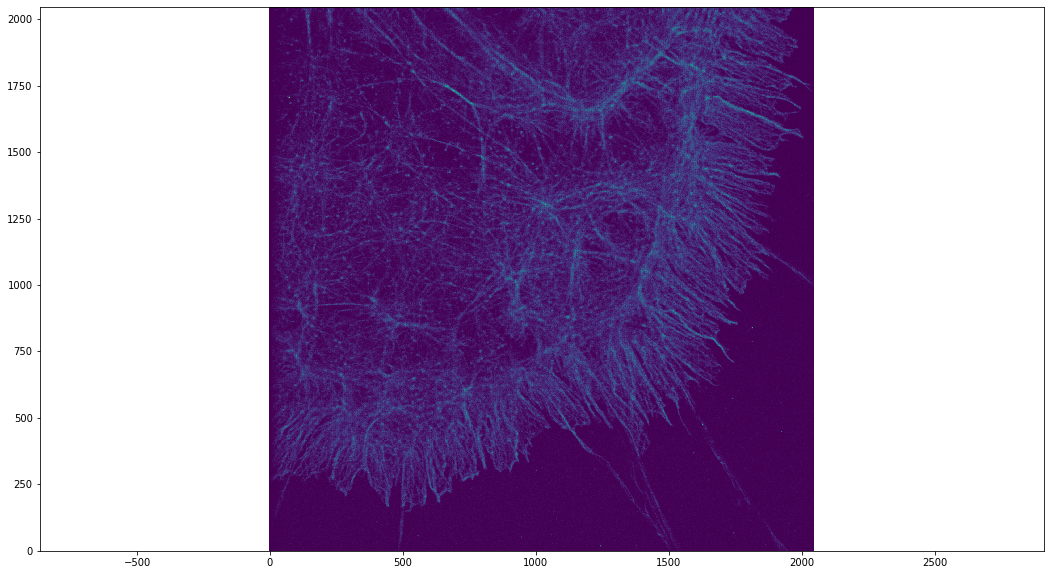

<Figure size 1296x720 with 0 Axes>

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
from skimage.registration import phase_cross_correlation
import numpy as np
from skimage.transform import AffineTransform, warp
from scipy.interpolate import UnivariateSpline
from IPython import display

path = '/content/gdrive/MyDrive/Deepstormdata/locs2.csv'

# df = pd.DataFrame()
# c = 1
# for chunk in pd.read_csv(path, header=None, names=['frames', 'x', 'y'], chunksize=10000):
#     display.clear_output(wait=True)
#     print(c)
#     df = pd.concat([df, chunk], ignore_index=True)
#     c+=1

df = pd.read_csv(path, names=['frames', 'x', 'y'], header=None)
#print(df.x)

# fig = plt.figure(figsize=(18,10))
# plt.hist2d(df.x,df.y,bins=(2045,2045),vmin=0.01, vmax = 20)
# plt.axis('equal')
#print(df)
bins = 20
maxframes = int(np.max(df.frames))

step = int(maxframes/bins)
print(maxframes)
#print(maxframes)
b = step
#index = df[(df.frames < bin)]
xedges = [x for x in range(2045)]
yedges = [y for y in range(2045)]
frame1 = df[(df.frames < b) & (df.frames > (b-step))]
refimg, hxedges, hyedges = np.histogram2d(frame1.x,frame1.y,bins=(xedges,yedges))
extent = [hyedges[0], hyedges[-1], hxedges[0], hxedges[-1]]
# fig = plt.figure(figsize=(18, 10), dpi=80, facecolor='w', edgecolor='k')
# plt.imshow(refimg,extent=extent,vmax=2)
drift = [[0,0],[0,0]]

for b in range(step*2,maxframes,round(step)):
    print(b)
    movingDF = df[(df.frames < b) & (df.frames > (b-step))]
    movingimage, hxedges, hyedges = np.histogram2d(movingDF.x,movingDF.y,bins=(xedges,yedges))
    shift, error, diffphase = phase_cross_correlation(refimg, movingimage,upsample_factor=100)
    drift.append(shift.tolist())
#print(drift)
smoothing = 0.1
x = [x[0] for x in drift] + [drift[-1][0]]
y = [y[1] for y in drift] + [drift[-1][1]]
t = [0] + [t for t in range(step//2,maxframes,step)] + [maxframes]
#print(len(t),len(x))
#Spline smoothing to reduce in correct drift spikes
usx = UnivariateSpline(t, x)
usy = UnivariateSpline(t, y)
usx.set_smoothing_factor(smoothing)
usy.set_smoothing_factor(smoothing)

#plt.plot(t,x)
#plt.plot(t,y)
subt = [subt/maxframes*max(t) for subt in range(maxframes)]
smoothx = usx(subt)
smoothy = usy(subt)

df.x = df.x+usx(df.frames)
df.y = df.y+usy(df.frames)

fig = plt.figure(figsize=(18,10))
plt.hist2d(df.x,df.y,bins=(2045,2045),range=[[0, 2045],[0, 2045]])
superres, hxedges, hyedges = np.histogram2d(df.x,df.y,bins=(xedges,yedges))
plt.axis('equal')
plt.show()
plt.draw()
tf.imwrite('/content/gdrive/MyDrive/Deepstormdata/superres.tif',superres)


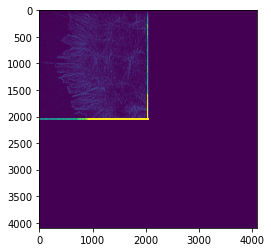

In [ ]:


# print(len(df[df.frames==1]))
# fig = plt.figure(figsize=(18,10))
# plt.hist2d(df.x,df.y,bins=(4096,4096),range=[[0, 2048],[0, 2048]],vmax=30)
# plt.axis('equal')
# plt.show()
# plt.draw()
xedges = [x/2 for x in range(2048*2)]
yedges = [y/2 for y in range(2048*2)]
locimage = np.zeros((2048*2,2048*2))
for p in range(len(df)):
    locimage[max(min(round(df.at[p,'x']*2),2047),0),max(min(round(df.at[p,'y']*2),2047),0)] += 1
                                                 
#refimg, hxedges, hyedges = np.histogram2d(df.x,df.y,bins=(xedges,yedges))
plt.imshow(locimage,vmax=20)
tf.imwrite('/content/gdrive/MyDrive/Deepstormdata/locs.tif',locimage)


In [6]:

print(str([1,2,3]))


[1, 2, 3]
